# Stats Compass Core - ARIMA Time Series Forecasting

This notebook demonstrates the ARIMA (AutoRegressive Integrated Moving Average) tools:
- `check_stationarity` - Test if a time series is stationary (ADF and KPSS tests)
- `infer_frequency` - Detect the frequency of your time series data
- `fit_arima` - Fit an ARIMA model with specified (p,d,q) parameters
- `find_optimal_arima` - Automatically search for best ARIMA parameters
- `forecast_arima` - Generate future predictions with confidence intervals

**Dataset**: TATA Steel historical stock prices (daily data from 2000-2021)

In [60]:
# Setup
from stats_compass_core import DataFrameState
from stats_compass_core.ml.arima import (
    fit_arima, FitARIMAInput,
    forecast_arima, ForecastARIMAInput,
    find_optimal_arima, FindOptimalARIMAInput,
    check_stationarity, StationarityTestInput,
    infer_frequency, InferFrequencyInput,
)
from stats_compass_core.plots import lineplot
from stats_compass_core.plots.lineplot import LinePlotInput
import pandas as pd
from IPython.display import Image, display
import base64

# Initialize state
state = DataFrameState()
print("Stats Compass Core ARIMA tools ready!")

Stats Compass Core ARIMA tools ready!


In [61]:
# Load TATA Steel stock data using the built-in dataset loader
from stats_compass_core.data import load_dataset

df = load_dataset('TATASTEEL', parse_dates=['Date'])

# Use recent data (last 3 years) for faster demos
df = df[df['Date'] >= '2018-01-01'].reset_index(drop=True)
df = df.sort_values('Date')

state.set_dataframe(df, name='stock_data', operation='load')
print(f"Loaded {len(df)} rows from {df['Date'].min()} to {df['Date'].max()}")
df[['Date', 'Close', 'Volume']].head(10)

Loaded 823 rows from 2018-01-01 00:00:00 to 2021-04-30 00:00:00


,Date,Close,Volume
0,2018-01-01,722.20,1833942
1,2018-01-02,729.30,2467294
2,2018-01-03,734.95,2634779
3,2018-01-04,760.25,8082986
4,2018-01-05,770.70,7136203
5,2018-01-08,768.75,2584335
6,2018-01-09,772.30,3197787
7,2018-01-10,772.85,2990882
8,2018-01-11,770.95,1934937
9,2018-01-12,770.25,2169940


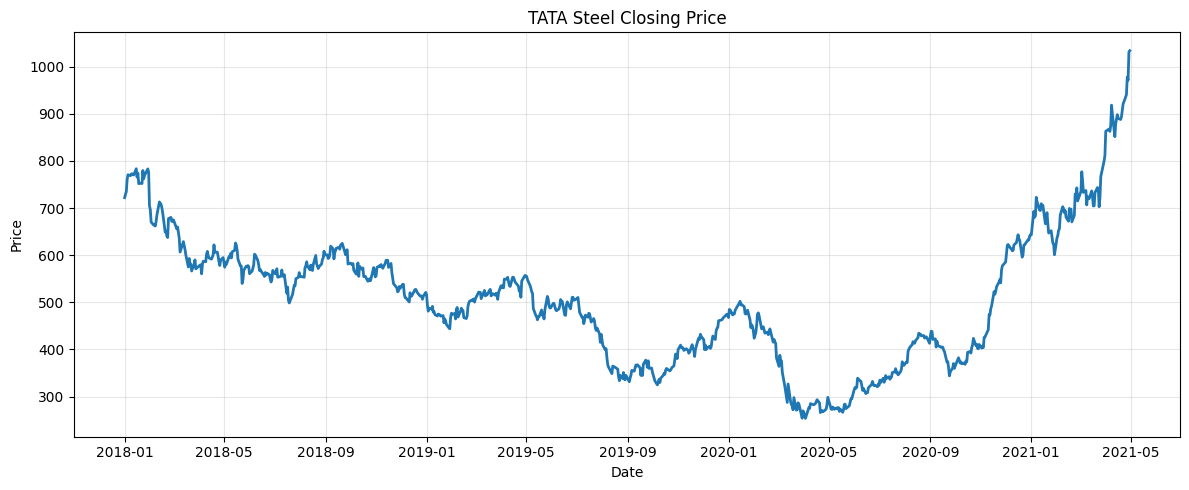

In [62]:
# Quick visualization of the closing price using lineplot tool
result = lineplot(state, LinePlotInput(
    dataframe_name='stock_data',
    x_column='Date',
    y_column='Close',
    title='TATA Steel Closing Price',
    xlabel='Date',
    ylabel='Price',
    figsize=(12, 5)
))

display(Image(data=base64.b64decode(result.image_base64)))

---
## 1. Infer Frequency

Before working with time series, it's helpful to understand the data frequency.
The `infer_frequency` tool automatically detects this from your date column.

In [63]:
# Infer the frequency of the time series
result = infer_frequency(state, InferFrequencyInput(
    dataframe_name='stock_data',
    date_column='Date'
))

print(f"Frequency: {result.frequency_description}")
print(f"Timedelta: {result.frequency_timedelta}")
print(f"Days between observations: {result.frequency_days}")
print(f"\nDate range: {result.date_range}")
print(f"Observations: {result.n_observations}")
print(f"\nConversion examples:")
for period, steps in result.conversion_examples.items():
    print(f"  {period} = {steps} data points")

Frequency: daily
Timedelta: 1 days 00:00:00
Days between observations: 1.0

Date range: 2018-01-01 to 2021-04-30
Observations: 823

Conversion examples:
  7 days = 7 data points
  30 days = 30 data points
  3 months = 90 data points
  6 months = 180 data points
  1 year = 365 data points


---
## 2. Stationarity Testing

ARIMA models assume the time series is stationary (or can be made stationary through differencing).
Use `check_stationarity` to run ADF and/or KPSS tests.

In [64]:
# Run both ADF and KPSS tests
import warnings
warnings.filterwarnings('ignore')

stationarity_result = check_stationarity(state, StationarityTestInput(
    dataframe_name='stock_data',
    target_column='Close',
    test_type='both'
))

# Result is a list with [adf_result, kpss_result]
adf, kpss = stationarity_result[0], stationarity_result[1]

print("=== ADF Test (Null: Non-stationary) ===")
print(f"Test Statistic: {adf.test_statistic:.4f}")
print(f"P-value: {adf.p_value:.4f}")
print(f"Stationary: {adf.is_stationary}")
print(f"Interpretation: {adf.interpretation}")

print("\n=== KPSS Test (Null: Stationary) ===")
print(f"Test Statistic: {kpss.test_statistic:.4f}")
print(f"P-value: {kpss.p_value:.4f}")
print(f"Stationary: {kpss.is_stationary}")
print(f"Interpretation: {kpss.interpretation}")

=== ADF Test (Null: Non-stationary) ===
Test Statistic: 0.8601
P-value: 0.9925
Stationary: False
Interpretation: ADF test statistic: 0.8601 (p-value: 0.9925). The series is NOT stationary (p >= 0.05). Consider differencing (d >= 1).

=== KPSS Test (Null: Stationary) ===
Test Statistic: 0.9030
P-value: 0.0100
Stationary: False
Interpretation: KPSS test statistic: 0.9030 (p-value: 0.0100). The series is NOT stationary (p <= 0.05). Consider differencing.


---
## 3. Find Optimal ARIMA Parameters

Instead of manually trying different (p,d,q) combinations, use `find_optimal_arima` 
to automatically search for the best parameters based on AIC or BIC criteria.

In [65]:
# Auto-find optimal ARIMA parameters
result = find_optimal_arima(state, FindOptimalARIMAInput(
    dataframe_name='stock_data',
    target_column='Close',
    date_column='Date',
    max_p=3,       # Try AR orders 0-3
    max_d=2,       # Try differencing 0-2
    max_q=3,       # Try MA orders 0-3
    criterion='aic',  # Use AIC for model selection
    top_n=5        # Show top 5 models
))

if result.success:
    print(f"Best model: ARIMA{result.best_order}")
    print(f"Best AIC: {result.best_aic:.2f}")
    print(f"\nTop {len(result.top_models)} models by AIC:")
    for i, model in enumerate(result.top_models, 1):
        print(f"  {i}. ARIMA{model['order']} - AIC: {model['aic']:.2f}")
    print(f"\nModels evaluated: {result.models_evaluated}")
    print(f"Search time: {result.search_time_seconds:.1f}s")
else:
    print(f"Search failed: {result}")

Best model: ARIMA(0, 2, 1)
Best AIC: 6561.30

Top 5 models by AIC:
  1. ARIMA(0, 2, 1) - AIC: 6561.30
  2. ARIMA(2, 2, 3) - AIC: 6561.68
  3. ARIMA(0, 2, 2) - AIC: 6562.47
  4. ARIMA(1, 2, 1) - AIC: 6562.52
  5. ARIMA(3, 2, 3) - AIC: 6563.72

Models evaluated: 48
Search time: 6.2s


---
## 4. Fit ARIMA Model

Fit an ARIMA model with specific parameters. You can use the optimal parameters 
found above, or specify your own based on domain knowledge.

In [66]:
# Fit ARIMA with optimal parameters from the search
best_p, best_d, best_q = result.best_order

fit_result = fit_arima(state, FitARIMAInput(
    dataframe_name='stock_data',
    target_column='Close',
    date_column='Date',
    p=best_p,
    d=best_d,
    q=best_q,
    model_name='stock_arima'
))

print(f"Model: ARIMA{fit_result.order}")
print(f"AIC: {fit_result.aic:.2f}")
print(f"BIC: {fit_result.bic:.2f}")
print(f"Observations: {fit_result.n_observations}")
print(f"Residual Std: {fit_result.residual_std:.4f}")
print(f"\nModel ID: {fit_result.model_id}")

Model: ARIMA(0, 2, 1)
AIC: 6561.30
BIC: 6570.72
Observations: 823
Residual Std: 30.9391

Model ID: stock_arima_20251210_223511


In [67]:
# Fit with the optimal parameters found earlier (if available)
if 'result' in dir() and hasattr(result, 'best_order') and result.best_order:
    best_p, best_d, best_q = result.best_order
    
    optimal_result = fit_arima(state, FitARIMAInput(
        dataframe_name='stock_data',
        target_column='Close',
        date_column='Date',
        p=best_p,
        d=best_d,
        q=best_q,
        model_name='stock_optimal_arima'
    ))
    
    if optimal_result.success:
        print(f"Optimal Model: ARIMA{optimal_result.order}")
        print(f"AIC: {optimal_result.aic:.2f}")
        print(f"Model ID: {optimal_result.model_id}")

Optimal Model: ARIMA(0, 2, 1)
AIC: 6561.30
Model ID: stock_optimal_arima_20251210_223511


---
## 5. Generate Forecasts

Use the fitted model to forecast future values. You can specify:
- `n_periods`: Direct number of steps to forecast
- `forecast_number` + `forecast_unit`: Natural language like "30 days" or "3 months"

In [68]:
# Forecast using n_periods (direct number of steps)
# Use the model_id returned from fit_arima (includes timestamp)
forecast_result = forecast_arima(state, ForecastARIMAInput(
    model_id=fit_result.model_id,  # Use the actual model ID from fit
    n_periods=30,                   # Forecast 30 data points
    confidence_level=0.95,          # 95% confidence interval
    include_plot=True               # Generate visualization
))

if forecast_result.success:
    print(f"Forecast generated for {forecast_result.n_periods} periods")
    print(f"Forecast dates: {forecast_result.forecast_index[0]} to {forecast_result.forecast_index[-1]}")
    
    # Show first few forecasted values
    print("\nFirst 5 forecasted values:")
    for i, val in enumerate(forecast_result.forecast_values[:5]):
        print(f"  Step {i+1}: {val:.2f}")
else:
    print(f"Forecast failed: {forecast_result}")

Forecast generated for 30 periods
Forecast dates: 823 to 852

First 5 forecasted values:
  Step 1: 1038.82
  Step 2: 1043.64
  Step 3: 1048.46
  Step 4: 1053.29
  Step 5: 1058.11


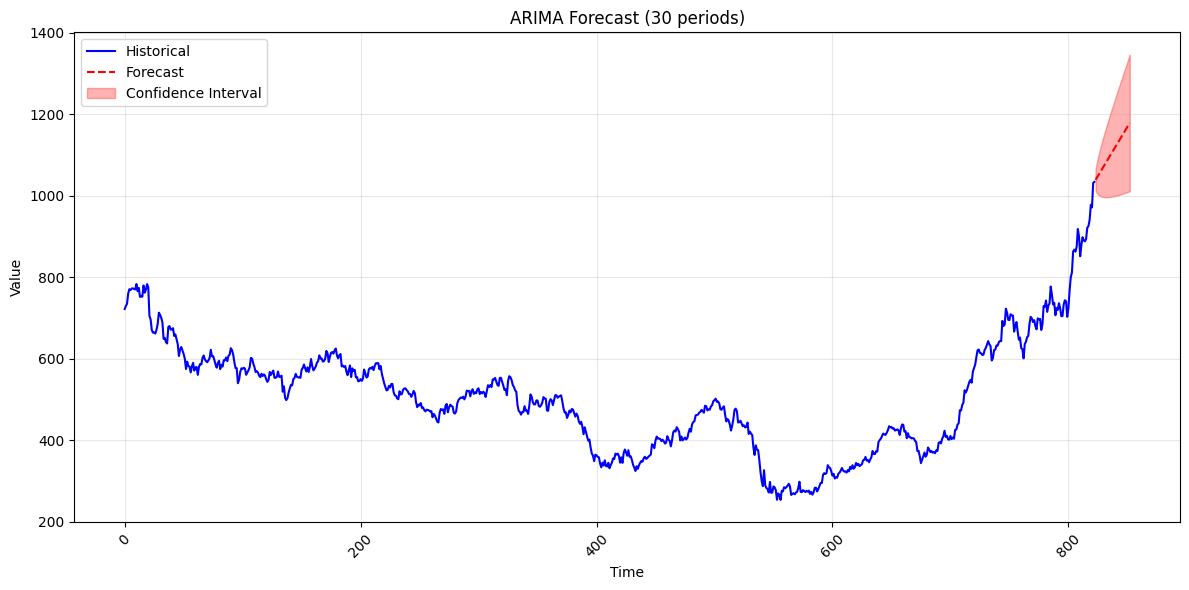

In [69]:
# Display the forecast plot
if forecast_result.success and forecast_result.image_base64:
    from IPython.display import Image, display
    import base64
    display(Image(data=base64.b64decode(forecast_result.image_base64)))

3-month forecast generated
Actual periods forecasted: 365
Date range: 823 to 1187


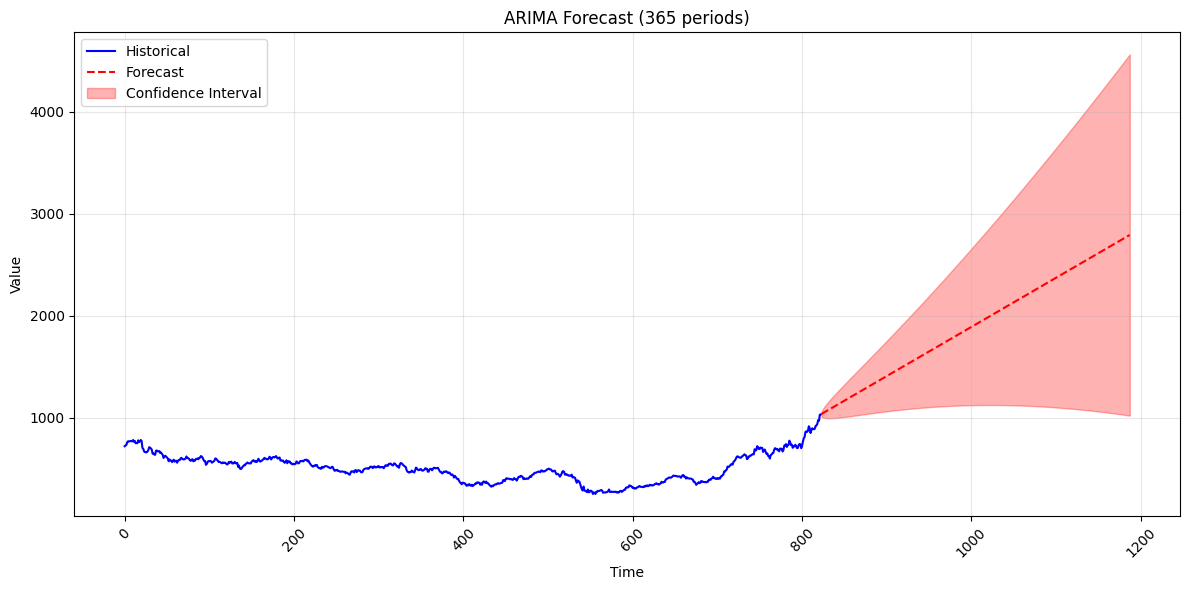

In [70]:
# Forecast using natural language: "3 months ahead"
forecast_3m = forecast_arima(state, ForecastARIMAInput(
    model_id=fit_result.model_id,  # Use the actual model ID from fit
    forecast_number=3,              # 3 of the time unit below
    forecast_unit='months',         # 'days', 'weeks', 'months', 'quarters', 'years'
    confidence_level=0.95,
    include_plot=True
))

print(f"3-month forecast generated")
print(f"Actual periods forecasted: {forecast_3m.n_periods}")
print(f"Date range: {forecast_3m.forecast_index[0]} to {forecast_3m.forecast_index[-1]}")

if forecast_3m.image_base64:
    display(Image(data=base64.b64decode(forecast_3m.image_base64)))

---
## 6. Working with Forecast Data

The forecast results include all the data you need for further analysis:
- Point forecasts
- Confidence intervals
- Dates/indices

In [71]:
# Create a DataFrame from forecast results for further analysis
forecast_df = pd.DataFrame({
    'date': forecast_result.forecast_index,
    'forecast': forecast_result.forecast_values,
    'lower_ci': forecast_result.lower_ci,
    'upper_ci': forecast_result.upper_ci,
})

print("Forecast DataFrame:")
forecast_df.head(10)

Forecast DataFrame:


,date,forecast,lower_ci,upper_ci
0,823,1038.821631,1013.153951,1064.489311
1,824,1043.643262,1007.108858,1080.177666
2,825,1048.464893,1003.431374,1093.498412
3,826,1053.286524,1000.952841,1105.620207
4,827,1058.108155,999.223764,1116.992546
5,828,1062.929786,998.015162,1127.844409
6,829,1067.751417,997.191909,1138.310925
7,830,1072.573048,996.666540,1148.479556
8,831,1077.394679,996.378699,1158.410659
9,832,1082.216310,996.284729,1168.147890


In [72]:
# Calculate forecast statistics
if forecast_result.success:
    print("Forecast Summary Statistics:")
    print(f"  Mean forecast: {sum(forecast_result.forecast_values)/len(forecast_result.forecast_values):.2f}")
    print(f"  Forecast range: {min(forecast_result.forecast_values):.2f} - {max(forecast_result.forecast_values):.2f}")
    
    # Average confidence interval width
    ci_widths = [u - l for u, l in zip(forecast_result.upper_ci, forecast_result.lower_ci)]
    print(f"  Avg CI width: {sum(ci_widths)/len(ci_widths):.2f}")
    print(f"  CI width grows over time: {ci_widths[0]:.2f} → {ci_widths[-1]:.2f}")

Forecast Summary Statistics:
  Mean forecast: 1108.74
  Forecast range: 1038.82 - 1178.65
  Avg CI width: 213.69
  CI width grows over time: 51.34 → 335.23


---
## 7. Comparing Models

You can fit multiple models and compare their performance.

In [73]:
# Fit multiple models for comparison
models_to_try = [
    (1, 1, 0),  # AR(1) with differencing
    (0, 1, 1),  # MA(1) with differencing
    (1, 1, 1),  # ARIMA(1,1,1)
    (2, 1, 2),  # ARIMA(2,1,2)
]

results = []
for p, d, q in models_to_try:
    fit_result = fit_arima(state, FitARIMAInput(
        dataframe_name='stock_data',
        target_column='Close',
        date_column='Date',
        p=p, d=d, q=q,
        model_name=f'comparison_{p}_{d}_{q}'
    ))
    
    if fit_result.success:
        results.append({
            'order': f'ARIMA({p},{d},{q})',
            'aic': fit_result.aic,
            'bic': fit_result.bic,
            'residual_std': fit_result.residual_std,
            'model_id': fit_result.model_id
        })

# Display comparison
comparison_df = pd.DataFrame(results).sort_values('aic')
print("Model Comparison (sorted by AIC):")
comparison_df

Model Comparison (sorted by AIC):


,order,aic,bic,residual_std,model_id
3,"ARIMA(2,1,2)",6567.309566,6590.868268,28.330719,comparison_2_1_2_20251210_223511
1,"ARIMA(0,1,1)",6571.907320,6581.330800,28.368522,comparison_0_1_1_20251210_223511
0,"ARIMA(1,1,0)",6571.907955,6581.331436,28.368530,comparison_1_1_0_20251210_223511
2,"ARIMA(1,1,1)",6573.920729,6588.055950,28.368600,comparison_1_1_1_20251210_223511


---
## Summary

**ARIMA Tools Available:**

| Tool | Purpose | Key Parameters |
|------|---------|----------------|
| `infer_frequency` | Detect data frequency | `date_column` |
| `check_stationarity` | Test stationarity | `target_column`, `test_type` |
| `find_optimal_arima` | Auto-find best (p,d,q) | `max_p`, `max_d`, `max_q`, `criterion` |
| `fit_arima` | Fit ARIMA model | `p`, `d`, `q`, `target_column`, `date_column` |
| `forecast_arima` | Generate forecasts | `model_id`, `n_periods` OR `forecast_number`+`forecast_unit` |

**Tips:**
1. Always check stationarity first - ARIMA assumes stationarity
2. Use `find_optimal_arima` for automatic parameter selection
3. Lower AIC/BIC = better model (trade-off between fit and complexity)
4. Confidence intervals widen as you forecast further into the future
5. For daily data with gaps (weekends), the tool handles this automatically

In [74]:
# List all models stored in state
print("Models in state:")
for model_id in state.list_models():
    print(f"  - {model_id}")

Models in state:
  - model_id='stock_arima_20251210_223511' model_type='arima' target_column='Close' feature_columns=[] created_at='2025-12-10T22:35:11.238710' source_dataframe='stock_data'
  - model_id='stock_optimal_arima_20251210_223511' model_type='arima' target_column='Close' feature_columns=[] created_at='2025-12-10T22:35:11.279907' source_dataframe='stock_data'
  - model_id='comparison_1_1_0_20251210_223511' model_type='arima' target_column='Close' feature_columns=[] created_at='2025-12-10T22:35:11.700512' source_dataframe='stock_data'
  - model_id='comparison_0_1_1_20251210_223511' model_type='arima' target_column='Close' feature_columns=[] created_at='2025-12-10T22:35:11.714383' source_dataframe='stock_data'
  - model_id='comparison_1_1_1_20251210_223511' model_type='arima' target_column='Close' feature_columns=[] created_at='2025-12-10T22:35:11.730528' source_dataframe='stock_data'
  - model_id='comparison_2_1_2_20251210_223511' model_type='arima' target_column='Close' featur